<a href="https://colab.research.google.com/github/mjsonu/Fellowship/blob/main/FellowShip_MohitJena_ResNet%2050_Flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy scipy matplotlib tensorflow

In [2]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from scipy.io import loadmat
import tarfile


In [3]:
# Specify paths to the files
flowers_tgz_path = '/content/102flowers.tgz'
segmentations_tgz_path = '/content/102segmentations.tgz'
imagelabels_mat_path = '/content/imagelabels.mat'
setid_mat_path = '/content/setid.mat'

# Extract dataset files
for file_path in [flowers_tgz_path, segmentations_tgz_path]:
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall('./data')  # Extract to a generic 'data' directory
print("Dataset files extracted.")


Dataset files extracted.


In [4]:
# Load image labels and dataset splits
labels_data = loadmat(imagelabels_mat_path)
setid_data = loadmat(setid_mat_path)

# Extract labels and splits
image_labels = labels_data['labels'][0]  # 1-based indexing
train_ids = setid_data['trnid'][0] - 1  # Convert to 0-based indexing
valid_ids = setid_data['valid'][0] - 1
test_ids = setid_data['tstid'][0] - 1

# Display dataset info
print(f"Total images: {len(image_labels)}")
print(f"Training images: {len(train_ids)}, Validation images: {len(valid_ids)}, Test images: {len(test_ids)}")


Total images: 8189
Training images: 1020, Validation images: 1020, Test images: 6149


In [5]:
# Define the path to the image directory
image_dir = './data/jpg'  # Adjust this if images are extracted to a different folder

# Function to preprocess images
def preprocess_images(image_ids, labels):
    images, targets = [], []
    for i in image_ids:
        image_path = os.path.join(image_dir, f'image_{i+1:05d}.jpg')
        img = load_img(image_path, target_size=(224, 224))  # Resize images
        img_array = img_to_array(img)  # Convert to NumPy array
        img_array = preprocess_input(img_array)  # Normalize for ResNet50
        images.append(img_array)
        targets.append(labels[i] - 1)  # Convert labels to 0-based indexing
    return np.array(images), np.array(targets)

# Preprocess train, validation, and test datasets
train_images, train_labels = preprocess_images(train_ids, image_labels)
valid_images, valid_labels = preprocess_images(valid_ids, image_labels)
test_images, test_labels = preprocess_images(test_ids, image_labels)

# Print shapes of datasets
print(f"Training images shape: {train_images.shape}")
print(f"Validation images shape: {valid_images.shape}")
print(f"Test images shape: {test_images.shape}")


Training images shape: (1020, 224, 224, 3)
Validation images shape: (1020, 224, 224, 3)
Test images shape: (6149, 224, 224, 3)


In [6]:
# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers for classification
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(102, activation='softmax')  # 102 flower categories
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 102)                 │         208,998 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,796,710 (90.78 MB)

 Trainable params: 208,998 (816.40 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 526ms/step - accuracy: 0.0819 - loss: 4.8672 - val_accuracy: 0.4520 - val_loss: 2.5786
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 177ms/step - accuracy: 0.7087 - loss: 1.7387 - val_accuracy: 0.6990 - val_loss: 1.5001
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.9297 - loss: 0.6766 - val_accuracy: 0.7725 - val_loss: 1.1384
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.9838 - loss: 0.3623 - val_accuracy: 0.8176 - val_loss: 0.9551
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.9934 - loss: 0.2352 - val_accuracy: 0.8333 - val_loss: 0.8578
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - accuracy: 0.9949 - loss: 0.1595 - val_accuracy: 0.8382 - val_loss: 0.7952
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 1.0000 - loss: 0.1010 - val_accuracy: 0.8520 - val_loss: 0.7558
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 1.0000 - loss: 0.0795 - val_accuracy

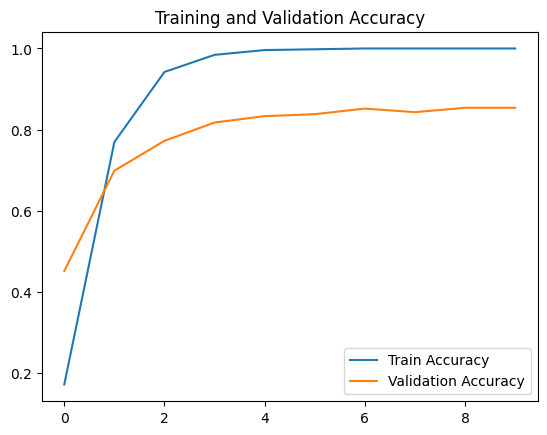

In [7]:
# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(valid_images, valid_labels),
    epochs=10,
    batch_size=32
)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()


In [8]:
import gc
from tensorflow.keras import backend as K

# Clean up RAM
def clean_memory():
    gc.collect()  # Garbage collection to free memory
    K.clear_session()  # Clear TensorFlow/Keras backend session
    print("Memory cleaned.")

# Call the function
clean_memory()

Memory cleaned.


In [9]:
# Function for batch-wise evaluation
def evaluate_model_in_batches(model, images, labels, batch_size=32):
    """
    Evaluate the model on the dataset in batches to save memory.

    Parameters:
        model (tf.keras.Model): Trained model.
        images (np.array): Dataset images.
        labels (np.array): Ground-truth labels.
        batch_size (int): Number of samples per batch.

    Returns:
        float, float: Average loss and accuracy over all batches.
    """
    num_samples = len(images)
    total_loss, total_accuracy = 0, 0
    num_batches = (num_samples + batch_size - 1) // batch_size  # Ceiling division

    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = min(batch_start + batch_size, num_samples)
        batch_images = images[batch_start:batch_end]
        batch_labels = labels[batch_start:batch_end]

        # Evaluate on the batch
        loss, accuracy = model.evaluate(batch_images, batch_labels, verbose=0)
        total_loss += loss * len(batch_images)
        total_accuracy += accuracy * len(batch_images)

    # Calculate average loss and accuracy
    avg_loss = total_loss / num_samples
    avg_accuracy = total_accuracy / num_samples

    return avg_loss, avg_accuracy

# Evaluate the model in batches
test_loss, test_accuracy = evaluate_model_in_batches(model, test_images, test_labels, batch_size=32)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.8056, Test Accuracy: 0.8297


In [10]:
# Save the model
model.save('my_model.keras')
print("Model saved successfully.")


Model saved successfully.


In [15]:
test_images.shape

(6149, 224, 224, 3)

In [16]:
clean_memory()

Memory cleaned.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


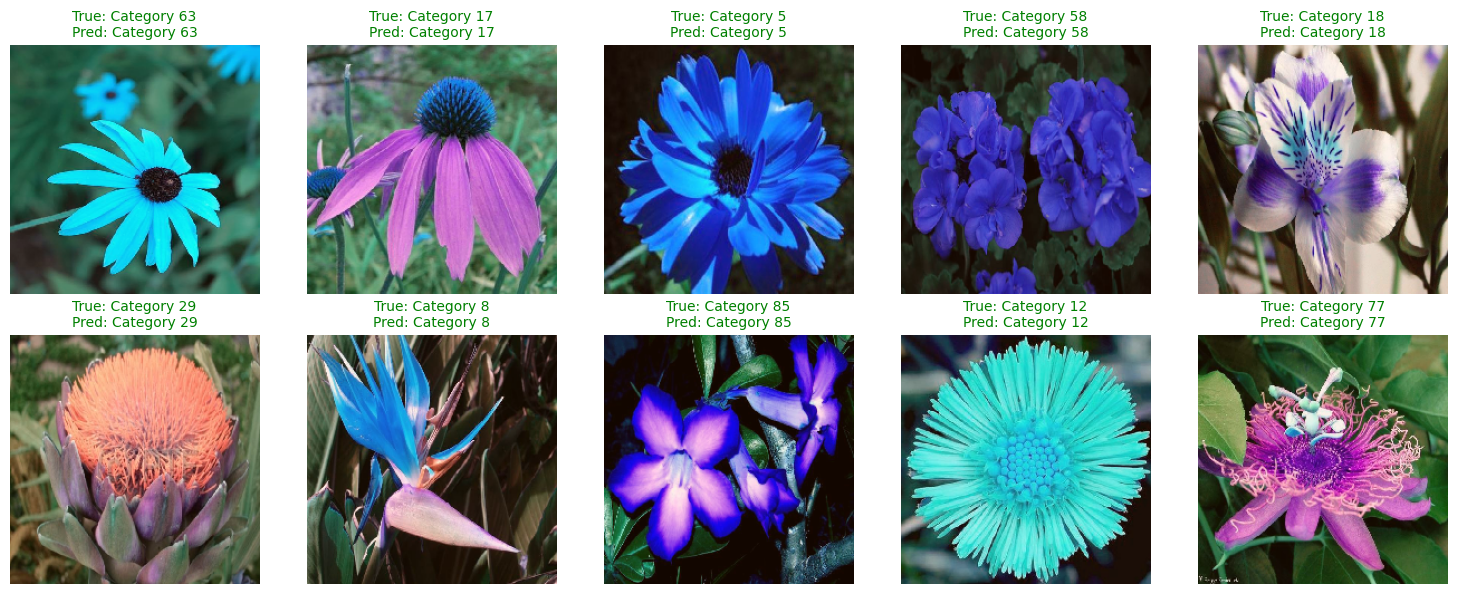

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img

# Step 1: Load the trained model
model = tf.keras.models.load_model('/content/my_model.keras')  # Replace 'saved_model_path' with your model's path

# Step 2: Randomly select 10 images from the test dataset
num_samples = 10
indices = np.random.choice(len(test_images), num_samples, replace=False)  # Randomly sample 10 indices
sample_images = test_images[indices]  # Get the images
sample_true_labels = test_labels[indices]  # Get the corresponding true labels

# Step 3: Predict labels for the sampled images
predictions = model.predict(sample_images)
sample_predicted_labels = np.argmax(predictions, axis=1)  # Get predicted class indices

# List of class names (adjust to your dataset)
class_names = [f"Category {i+1}" for i in range(102)]  # Replace with your actual class names

# Step 4: Visualize the sampled images with true and predicted labels
def visualize_predictions(images, true_labels, predicted_labels, class_names):
    """
    Visualize the sampled test images with true and predicted labels in rows of 5.

    Parameters:
        images (np.array): Array of test images.
        true_labels (np.array): Ground-truth labels.
        predicted_labels (np.array): Predicted labels by the model.
        class_names (list): List of class names.
    """
    num_samples = len(images)
    num_columns = 5  # Number of images per row
    num_rows = (num_samples + num_columns - 1) // num_columns  # Calculate the number of rows

    plt.figure(figsize=(15, num_rows * 3))  # Adjust figure size based on the number of rows
    for i in range(num_samples):
        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(array_to_img(images[i]))  # Convert image back to a displayable format
        true_label = class_names[true_labels[i]]
        pred_label = class_names[predicted_labels[i]]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
        plt.axis('off')
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()


# Visualize the sampled predictions
visualize_predictions(sample_images, sample_true_labels, sample_predicted_labels, class_names)
